In [1]:
import matplotlib.pyplot as plt
import seaborn
import random
import math
import pickle
import json
import numpy as np
import pandas as pd
from collections import defaultdict
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings('ignore')

random_state = 37

In [2]:
mimic = pd.read_csv("../data/processed/MIMIC_final.csv").drop(columns=['Unnamed: 0'], axis=1)
mimic.head()

,PATIENT_KEY,GENDER,Procedures_ICD_Features,Medication_NDC_Features,Lab_Chart_Features,Acute myocardial infarction,EHR_Features
0,10000764,0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,10000980,1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,10001492,1,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, ...",1,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,10001667,1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, ...",0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,10002155,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, ...",1,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [3]:
subj_ids = []
for i in range(len(mimic)):
    subjid = int(mimic["PATIENT_KEY"][i])
    subj_ids.append(subjid)
    
subj_ids = np.array(list(set(subj_ids)))
print(len(subj_ids))

14920


In [4]:
subj_train, subj_temp = train_test_split(subj_ids, test_size=0.2, random_state=random_state)
subj_val, subj_test = train_test_split(subj_temp, test_size=0.5, random_state=random_state)
print(len(subj_train), len(subj_val), len(subj_test))

11936 1492 1492


In [5]:
label = "Acute myocardial infarction"
y = np.array(list(mimic[label]))
X = np.load("../data/processed/MIMIC_X.npy")

X_train = []
X_val = []
X_test = []
y_train = []
y_val = []
y_test = []

for i in range(len(mimic)):
    features = X[i]
    label = y[i]
    subjid = int(mimic["PATIENT_KEY"][i])
    if(subjid in subj_train):
        X_train.append(np.array(features))
        y_train.append(label)
    elif(subjid in subj_val):
        X_val.append(np.array(features))
        y_val.append(label)
    else:
        X_test.append(np.array(features))
        y_test.append(label)
        
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(X_train.shape, len(y_train), X_val.shape, len(y_val), X_test.shape, len(y_test))

(11936, 766) 11936 (1492, 766) 1492 (1492, 766) 1492


In [6]:
reg_alpha = 0.1
reg_c = 0.5
reg_neighbors = 10
reg_estimators = 10
smote_sampling = 'auto'
under_sampling = 'auto'

In [8]:
models = [
    ('LR', LogisticRegression(class_weight='balanced', C=reg_c, max_iter=1000)),
    ('RF', RandomForestClassifier(class_weight='balanced', n_estimators=reg_estimators)),
    ('SVM', SVC(class_weight='balanced', C=reg_c)),
    ('MLP1', MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', max_iter=1000)),
    ('MLP2', MLPClassifier(hidden_layer_sizes=(50, 50), activation='logistic', max_iter=1000)),
    ('MLP3', MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', max_iter=1000)),
    ('MLP4', MLPClassifier(hidden_layer_sizes=(200, 100, 50), activation='logistic', max_iter=1000)),
    ('MLP5', MLPClassifier(hidden_layer_sizes=(300, 200, 100, 50), activation='logistic', max_iter=1000))]

model_metrics = {'Model': [], 'Train Accuracy': [], 'Validation Accuracy': [], 'Test Accuracy': [],
                 'Train AUCPRC': [], 'Validation AUCPRC': [], 'Test AUCPRC': [],
                 'Train AUROC': [], 'Validation AUROC': [], 'Test AUROC': []}

classification_reports = {}

for model_name, model in models:
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    auc_prc_train = average_precision_score(y_train, y_train_pred)
    auc_prc_val = average_precision_score(y_val, y_val_pred)
    auc_prc_test = average_precision_score(y_test, y_test_pred)
    auc_roc_train = roc_auc_score(y_train, y_train_pred)
    auc_roc_val = roc_auc_score(y_val, y_val_pred)
    auc_roc_test = roc_auc_score(y_test, y_test_pred)
    report_val = classification_report(y_val, y_val_pred)
    
    model_metrics['Model'].append(model_name)
    model_metrics['Train Accuracy'].append(accuracy_train)
    model_metrics['Validation Accuracy'].append(accuracy_val)
    model_metrics['Test Accuracy'].append(accuracy_test)
    model_metrics['Train AUCPRC'].append(auc_prc_train)
    model_metrics['Validation AUCPRC'].append(auc_prc_val)
    model_metrics['Test AUCPRC'].append(auc_prc_test)
    model_metrics['Train AUROC'].append(auc_roc_train)
    model_metrics['Validation AUROC'].append(auc_roc_val)
    model_metrics['Test AUROC'].append(auc_roc_test)
    classification_reports[model_name] = classification_report(y_val, y_val_pred)
    
    name = '../models/' + str(model_name) + "_model_EHR.pkl"
    with open(name, 'wb') as file:
        pickle.dump(model, file)
    
    print(model_name)
    print(f"Train Accuracy: {accuracy_train:.4f}")
    print(f"Validation Accuracy: {accuracy_val:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")
    print(f"Train AUCPRC: {auc_prc_train:.4f}")
    print(f"Validation AUCPRC: {auc_prc_val:.4f}")
    print(f"Test AUCPRC: {auc_prc_test:.4f}")
    print(f"Train AUROC: {auc_roc_train:.4f}")
    print(f"Validation AUROC: {auc_roc_val:.4f}")
    print(f"Test AUROC: {auc_roc_test:.4f}")
    print()

LR
Train Accuracy: 0.8683
Validation Accuracy: 0.8224
Test Accuracy: 0.8546
Train AUCPRC: 0.8450
Validation AUCPRC: 0.7869
Test AUCPRC: 0.8363
Train AUROC: 0.8694
Validation AUROC: 0.8232
Test AUROC: 0.8558

RF
Train Accuracy: 0.9913
Validation Accuracy: 0.8016
Test Accuracy: 0.8277
Train AUCPRC: 0.9906
Validation AUCPRC: 0.7633
Test AUCPRC: 0.8059
Train AUROC: 0.9916
Validation AUROC: 0.8020
Test AUROC: 0.8281

SVM
Train Accuracy: 0.8788
Validation Accuracy: 0.8365
Test Accuracy: 0.8539
Train AUCPRC: 0.8537
Validation AUCPRC: 0.7985
Test AUCPRC: 0.8287
Train AUROC: 0.8791
Validation AUROC: 0.8364
Test AUROC: 0.8527

MLP1
Train Accuracy: 1.0000
Validation Accuracy: 0.8358
Test Accuracy: 0.8338
Train AUCPRC: 1.0000
Validation AUCPRC: 0.7916
Test AUCPRC: 0.8046
Train AUROC: 1.0000
Validation AUROC: 0.8343
Test AUROC: 0.8312

MLP2
Train Accuracy: 1.0000
Validation Accuracy: 0.8023
Test Accuracy: 0.8143
Train AUCPRC: 1.0000
Validation AUCPRC: 0.7570
Test AUCPRC: 0.7874
Train AUROC: 1.0000


Text(0.5, 1.0, 'Model AUROC Comparison')

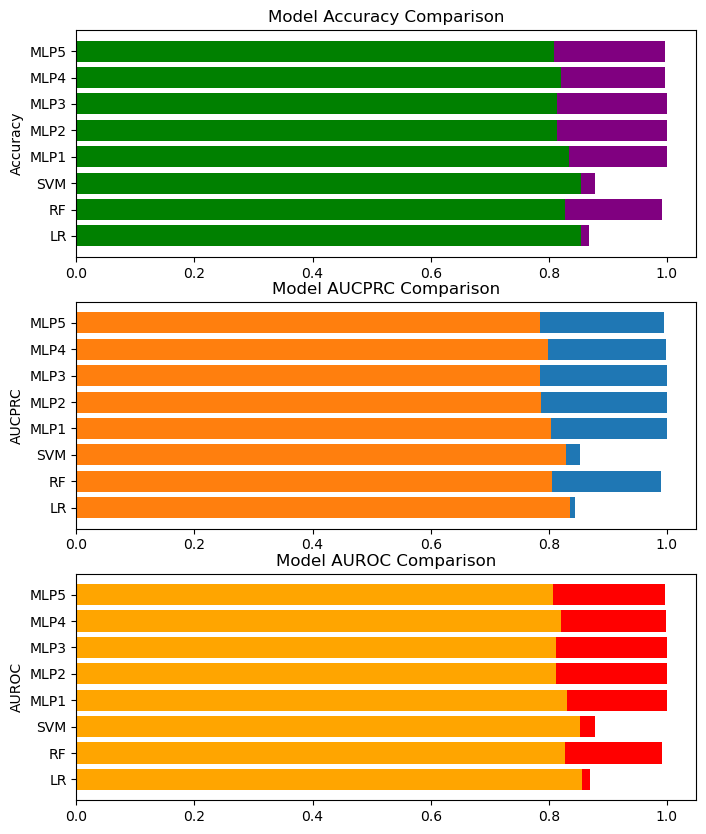

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))

# Plot Accuracy
axes[0].barh(model_metrics['Model'], model_metrics['Train Accuracy'], label='Train Accuracy', color='purple')
axes[0].barh(model_metrics['Model'], model_metrics['Test Accuracy'], label='Test Accuracy', alpha=1, color='green')
# axes[0].bar(model_metrics['Model'], model_metrics['Test Accuracy'], label='Test Accuracy', alpha=0.7)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
# axes[0].legend()

# Plot AUCPRC
axes[1].barh(model_metrics['Model'], model_metrics['Train AUCPRC'], label='Train AUCPRC')
axes[1].barh(model_metrics['Model'], model_metrics['Test AUCPRC'], label='Test AUCPRC', alpha=1)
# axes[1].bar(model_metrics['Model'], model_metrics['Test AUCPRC'], label='Test AUCPRC', alpha=0.7)
axes[1].set_ylabel('AUCPRC')
axes[1].set_title('Model AUCPRC Comparison')
# axes[1].legend()

# Plot AUROC
axes[2].barh(model_metrics['Model'], model_metrics['Train AUROC'], label='Train AUROC', color='red')
axes[2].barh(model_metrics['Model'], model_metrics['Test AUROC'], label='Test AUROC', alpha=1, color='orange')
# axes[2].bar(model_metrics['Model'], model_metrics['Test AUROC'], label='Test AUROC', alpha=0.7)
axes[2].set_ylabel('AUROC')
axes[2].set_title('Model AUROC Comparison')
# axes[2].legend()

## With Notes

In [7]:
p_subjids = np.load("../processing/subj_hadm_process/pancan_subj.npy")
n_subjids = np.load("../processing/subj_hadm_process/safe_subj.npy")
p_vecs = np.load("../processing/note_vectors/pancan_vectors.npy")
n_vecs = np.load("../processing/note_vectors/safe_vectors.npy")

print(p_subjids.shape, n_subjids.shape, p_vecs.shape, n_vecs.shape)

(8473,) (8643,) (8473, 768) (8643, 768)


In [8]:
label = "Acute myocardial infarction"
y = np.array(list(mimic[label]))
X = np.load("../data/processed/MIMIC_X.npy")
X_new = list(range(len(X)))

for i in range(len(mimic)):
    
    subjid = int(mimic["PATIENT_KEY"][i])
    if(subjid in p_subjids):
        X_new[i] = list(np.append(X[i], p_vecs[list(p_subjids).index(subjid)]))
    elif(subjid in n_subjids):
        X_new[i] = list(np.append(X[i], n_vecs[list(n_subjids).index(subjid)]))
        
X_new = np.array(X_new)
print(X_new.shape)

(14920, 1534)


In [9]:
X_train = []
X_val = []
X_test = []
y_train = []
y_val = []
y_test = []

for i in range(len(mimic)):
    features = X_new[i]
    label = y[i]
    subjid = int(mimic["PATIENT_KEY"][i])
    if(subjid in subj_train):
        X_train.append(np.array(features))
        y_train.append(label)
    elif(subjid in subj_val):
        X_val.append(np.array(features))
        y_val.append(label)
    else:
        X_test.append(np.array(features))
        y_test.append(label)
        
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(X_train.shape, len(y_train), X_val.shape, len(y_val), X_test.shape, len(y_test))

(11936, 1534) 11936 (1492, 1534) 1492 (1492, 1534) 1492


In [10]:
models = [
    ('LR_EHRNote', LogisticRegression(class_weight='balanced', C=reg_c, max_iter=1000)),
    ('RF_EHRNote', RandomForestClassifier(class_weight='balanced', n_estimators=reg_estimators,)),
    ('SVM_EHRNote', SVC(class_weight='balanced', C=reg_c)),
    ('MLP1_EHRNote', MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', max_iter=1000)),
    ('MLP2_EHRNote', MLPClassifier(hidden_layer_sizes=(50, 50), activation='logistic', max_iter=1000)),
    ('MLP3_EHRNote', MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', max_iter=1000)),
    ('MLP4_EHRNote', MLPClassifier(hidden_layer_sizes=(200, 100, 50), activation='logistic', max_iter=1000)),
    ('MLP5_EHRNote', MLPClassifier(hidden_layer_sizes=(300, 200, 100, 50), activation='logistic', max_iter=1000))]

model_metrics_EHRNote = {'Model': [], 'Train Accuracy': [], 'Validation Accuracy': [], 'Test Accuracy': [],
                 'Train AUCPRC': [], 'Validation AUCPRC': [], 'Test AUCPRC': [],
                 'Train AUROC': [], 'Validation AUROC': [], 'Test AUROC': []}

for model_name, model in models:
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    auc_prc_train = average_precision_score(y_train, y_train_pred)
    auc_prc_val = average_precision_score(y_val, y_val_pred)
    auc_prc_test = average_precision_score(y_test, y_test_pred)
    auc_roc_train = roc_auc_score(y_train, y_train_pred)
    auc_roc_val = roc_auc_score(y_val, y_val_pred)
    auc_roc_test = roc_auc_score(y_test, y_test_pred)
    report_val = classification_report(y_val, y_val_pred)
    
    model_metrics_EHRNote['Model'].append(model_name)
    model_metrics_EHRNote['Train Accuracy'].append(accuracy_train)
    model_metrics_EHRNote['Validation Accuracy'].append(accuracy_val)
    model_metrics_EHRNote['Test Accuracy'].append(accuracy_test)
    model_metrics_EHRNote['Train AUCPRC'].append(auc_prc_train)
    model_metrics_EHRNote['Validation AUCPRC'].append(auc_prc_val)
    model_metrics_EHRNote['Test AUCPRC'].append(auc_prc_test)
    model_metrics_EHRNote['Train AUROC'].append(auc_roc_train)
    model_metrics_EHRNote['Validation AUROC'].append(auc_roc_val)
    model_metrics_EHRNote['Test AUROC'].append(auc_roc_test)
    
    name = '../models/' + str(model_name) + "_model_EHR_Note.pkl"
    with open(name, 'wb') as file:
        pickle.dump(model, file)
    
    print(model_name)
    print(f"Train Accuracy: {accuracy_train:.4f}")
    print(f"Validation Accuracy: {accuracy_val:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")
    print(f"Train AUCPRC: {auc_prc_train:.4f}")
    print(f"Validation AUCPRC: {auc_prc_val:.4f}")
    print(f"Test AUCPRC: {auc_prc_test:.4f}")
    print(f"Train AUROC: {auc_roc_train:.4f}")
    print(f"Validation AUROC: {auc_roc_val:.4f}")
    print(f"Test AUROC: {auc_roc_test:.4f}")
    print()

LR_EHRNote
Train Accuracy: 0.8903
Validation Accuracy: 0.8525
Test Accuracy: 0.8753
Train AUCPRC: 0.8677
Validation AUCPRC: 0.8166
Test AUCPRC: 0.8529
Train AUROC: 0.8909
Validation AUROC: 0.8525
Test AUROC: 0.8747

RF_EHRNote
Train Accuracy: 0.9909
Validation Accuracy: 0.7849
Test Accuracy: 0.8016
Train AUCPRC: 0.9898
Validation AUCPRC: 0.7446
Test AUCPRC: 0.7809
Train AUROC: 0.9912
Validation AUROC: 0.7849
Test AUROC: 0.8025

SVM_EHRNote
Train Accuracy: 0.8673
Validation Accuracy: 0.8385
Test Accuracy: 0.8552
Train AUCPRC: 0.8400
Validation AUCPRC: 0.8016
Test AUCPRC: 0.8297
Train AUROC: 0.8674
Validation AUROC: 0.8386
Test AUROC: 0.8539

MLP1_EHRNote
Train Accuracy: 1.0000
Validation Accuracy: 0.8391
Test Accuracy: 0.8606
Train AUCPRC: 1.0000
Validation AUCPRC: 0.7963
Test AUCPRC: 0.8295
Train AUROC: 1.0000
Validation AUROC: 0.8379
Test AUROC: 0.8571

MLP2_EHRNote
Train Accuracy: 1.0000
Validation Accuracy: 0.8412
Test Accuracy: 0.8532
Train AUCPRC: 1.0000
Validation AUCPRC: 0.7984


Text(0.5, 1.0, 'Model AUROC Comparison')

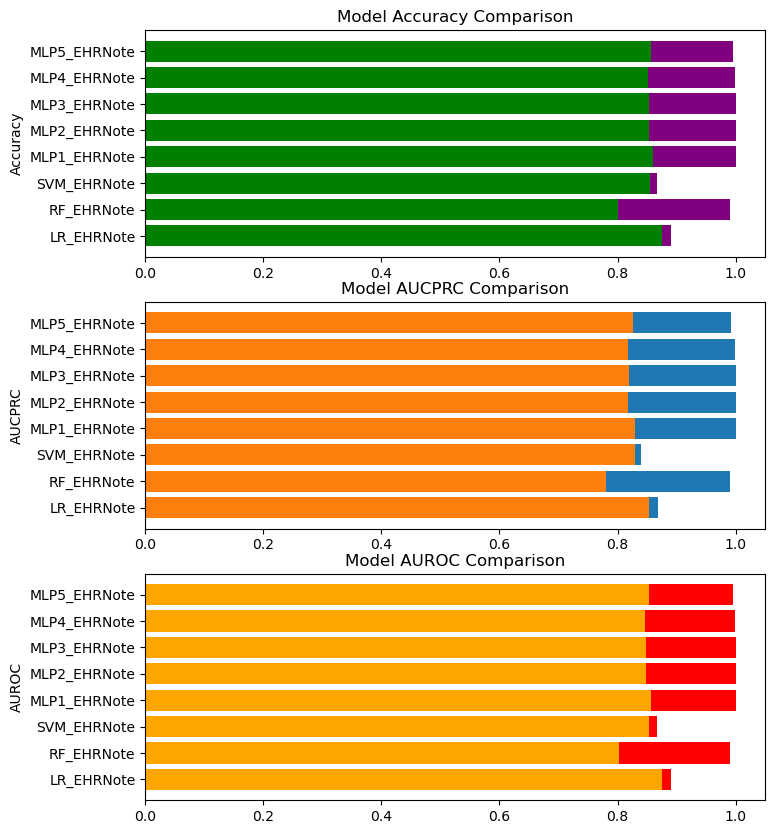

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))

# Plot Accuracy
axes[0].barh(model_metrics_EHRNote['Model'], model_metrics_EHRNote['Train Accuracy'], label='Train Accuracy', color='purple')
axes[0].barh(model_metrics_EHRNote['Model'], model_metrics_EHRNote['Test Accuracy'], label='Test Accuracy', alpha=1, color='green')
# axes[0].bar(model_metrics['Model'], model_metrics['Test Accuracy'], label='Test Accuracy', alpha=0.7)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
# axes[0].legend()

# Plot AUCPRC
axes[1].barh(model_metrics_EHRNote['Model'], model_metrics_EHRNote['Train AUCPRC'], label='Train AUCPRC')
axes[1].barh(model_metrics_EHRNote['Model'], model_metrics_EHRNote['Test AUCPRC'], label='Test AUCPRC', alpha=1)
# axes[1].bar(model_metrics['Model'], model_metrics['Test AUCPRC'], label='Test AUCPRC', alpha=0.7)
axes[1].set_ylabel('AUCPRC')
axes[1].set_title('Model AUCPRC Comparison')
# axes[1].legend()

# Plot AUROC
axes[2].barh(model_metrics_EHRNote['Model'], model_metrics_EHRNote['Train AUROC'], label='Train AUROC', color='red')
axes[2].barh(model_metrics_EHRNote['Model'], model_metrics_EHRNote['Test AUROC'], label='Test AUROC', alpha=1, color='orange')
# axes[2].bar(model_metrics['Model'], model_metrics['Test AUROC'], label='Test AUROC', alpha=0.7)
axes[2].set_ylabel('AUROC')
axes[2].set_title('Model AUROC Comparison')
# axes[2].legend()